In [ ]:
import os
import gdown
from zipfile import ZipFile

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torchsummary import summary
import torchvision
from torchvision.utils import make_grid
from torchvision import datasets
from torchvision import transforms

import time
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# hyper parameters
BATCH_SIZE = 64
size = (64, 64)
dim_latent_vector = 100

In [ ]:
from torchvision.transforms.transforms import Normalize
transform = transforms.Compose([
    transforms.Resize(size=size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [ ]:
# os.makedirs('celeba_gan')

# url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
# output = "celeba_gan/data.zip"
# gdown.download(url, output, quiet=True)



'celeba_gan/data.zip'

In [ ]:
with ZipFile(r'/content/drive/MyDrive/Colab_Notebooks/dataset/img_align_celeba.zip', "r") as zipobj:
    zipobj.extractall("celeba_gan")

In [ ]:
dataroot = '/content/celeba_gan'

dataset = datasets.ImageFolder(root=dataroot,
                           transform=transform)
print(len(dataset))

dataloader = data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


202599


In [ ]:
real_batch = next(iter(dataloader))
print(type(real_batch))
print(len(real_batch[0]))
print(np.shape(real_batch[0]))

<class 'list'>
64
torch.Size([64, 3, 64, 64])


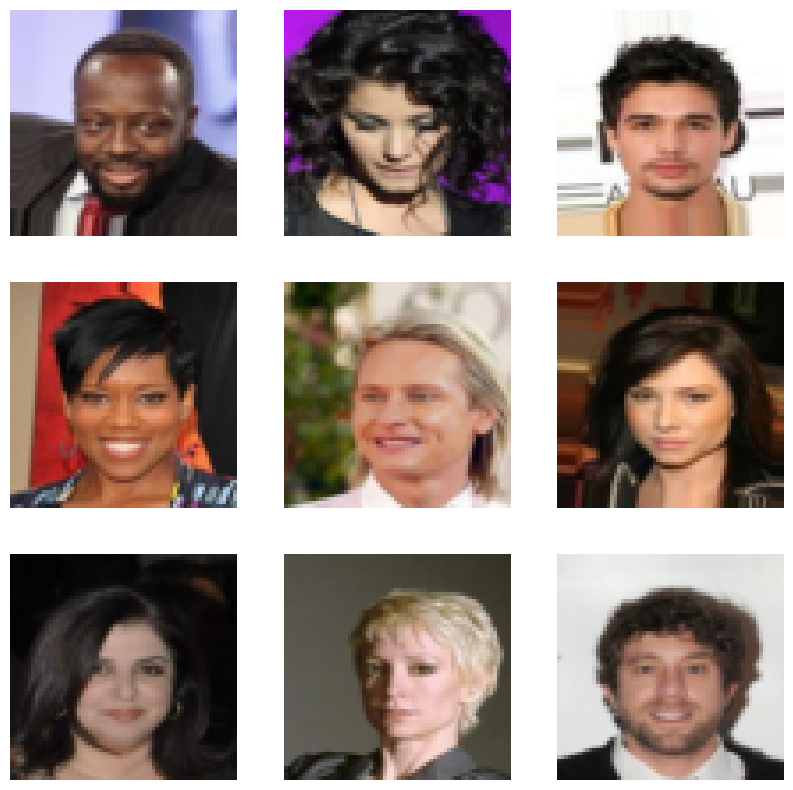

In [ ]:
plt.figure(figsize=(10,10))

for i in range(9):
    image = real_batch[0][i]
    # Making image (3, 64, 64) to (64, 64, 3)
    image = image.permute(1,2,0)
    # Making elements of arrays from [-1,1] to [0,1]
    image = (image+1)/2
    ax=plt.subplot(3,3,i+1)
    plt.imshow(image.numpy())
    plt.axis('off')

In [ ]:
def g_weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=2, stride=1, padding=0, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=0, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.generator(x)
        return x

In [ ]:
generator = Generator()
generator = generator.to(device)
generator.apply(g_weights_init)
print(generator)

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(2, 2), stride=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): ReLU(inplace=True)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): ReLU(inplace=True)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): ReLU(inplace=True)
    

In [ ]:
summary(generator, input_size=(100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 2, 2]         204,800
              ReLU-2            [-1, 512, 2, 2]               0
       BatchNorm2d-3            [-1, 512, 2, 2]           1,024
   ConvTranspose2d-4            [-1, 256, 4, 4]       1,179,648
              ReLU-5            [-1, 256, 4, 4]               0
       BatchNorm2d-6            [-1, 256, 4, 4]             512
   ConvTranspose2d-7            [-1, 128, 8, 8]         524,288
              ReLU-8            [-1, 128, 8, 8]               0
       BatchNorm2d-9            [-1, 128, 8, 8]             256
  ConvTranspose2d-10           [-1, 64, 16, 16]         131,072
             ReLU-11           [-1, 64, 16, 16]               0
      BatchNorm2d-12           [-1, 64, 16, 16]             128
  ConvTranspose2d-13           [-1, 32, 32, 32]          32,768
             ReLU-14           [-1, 32,

In [ ]:
def d_weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.uniform_(m.weight.data, -0.01, 0.01)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, -0.01, 0.01)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=1,kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.discriminator(x)
        return x

In [ ]:
discriminator = Discriminator()
discriminator = discriminator.to(device)
discriminator.apply(d_weights_init)
print(discriminator)

Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(256, 1, kernel_

In [ ]:
summary(discriminator, input_size=(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           1,536
         LeakyReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 64, 16, 16]          32,768
         LeakyReLU-5           [-1, 64, 16, 16]               0
       BatchNorm2d-6           [-1, 64, 16, 16]             128
            Conv2d-7            [-1, 128, 8, 8]         131,072
         LeakyReLU-8            [-1, 128, 8, 8]               0
       BatchNorm2d-9            [-1, 128, 8, 8]             256
           Conv2d-10            [-1, 256, 4, 4]         524,288
        LeakyReLU-11            [-1, 256, 4, 4]               0
      BatchNorm2d-12            [-1, 256, 4, 4]             512
           Conv2d-13              [-1, 1, 1, 1]           4,096
          Sigmoid-14              [-1, 

In [ ]:
class MyLossFunction(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, Y_pred, Y):
        Y_pred = Y_pred.to(device)
        loss = (Y*Y_pred - (torch.tensor([1]).to(device)-Y)*Y_pred).mean()
        return loss

In [ ]:
loss_ftn = MyLossFunction()
# criterion = nn.BCELoss()

fixed_noises = torch.randn(BATCH_SIZE, dim_latent_vector, 1, 1, device=device)

real_label = 1
fake_label = 0

d_optimizer = optim.RMSprop(discriminator.parameters(),lr = 5e-5)
g_optimizer = optim.RMSprop(generator.parameters(),lr = 5e-5)

In [ ]:
# Training Loop
num_critic = 5
num_epochs = 10

img_list = []
G_losses = []
D_losses = []
iters = 0

since = time.time()
print('Starting Training Loop...')
for epoch in range(num_epochs):
    for i, data in enumerate(tqdm(dataloader), 0):
        for _ in range(num_critic):
            # Update Discriminator: maximize log(D(x))+log(l-D(G(z)))
            # Train with all real batch
            discriminator.zero_grad()
            real_images = data[0].to(device)
            batch_size = real_images.size(0)
            label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
            real_output = discriminator(real_images).view(-1)
            d_loss_real = -loss_ftn(real_output, label)
            d_loss_real.backward()

            # Train with all fake batch
            noise = torch.randn(batch_size, dim_latent_vector, 1, 1, device=device)
            generated_images = generator(noise)
            label.fill_(fake_label)
            fake_output = discriminator(generated_images.detach()).view(-1)
            d_loss_fake = -loss_ftn(fake_output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            d_loss_fake.backward()
            d_loss = d_loss_real + d_loss_fake
            d_optimizer.step()
            for param in discriminator.parameters():
                param.data.clamp_(min=-0.01, max=0.01)

        # Update generator: maximize log(D(G(z)))
        generator.zero_grad()
        label.fill_(fake_label)
        g_output = discriminator(generated_images).view(-1)
        g_loss = loss_ftn(g_output, label)
        g_loss.backward()
        # D_G_z2 = g_output.mean().item()
        g_optimizer.step()

        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}] [{i}/{len(dataloader)}]\tLoss_D:{-d_loss.item():.4}\tLoss_G: {g_loss.item():.4}')

        # Save losses for plotting later
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                generated_imgs = generator(noise).detach().cpu()
            img_list.append(make_grid(generated_imgs, padding=2, normalize=True))

        iters += 1

time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed/60:.0f}m {time_elapsed%60:.0f}s')



Starting Training Loop...


  0%|          | 0/3166 [00:00<?, ?it/s]

[0/10] [0/3166]	Loss_D:-0.08051	Loss_G: -0.5725
[0/10] [50/3166]	Loss_D:0.1755	Loss_G: -0.413
[0/10] [100/3166]	Loss_D:0.1797	Loss_G: -0.41
[0/10] [150/3166]	Loss_D:0.1757	Loss_G: -0.4121
[0/10] [200/3166]	Loss_D:0.1795	Loss_G: -0.4098
[0/10] [250/3166]	Loss_D:0.1728	Loss_G: -0.4135
[0/10] [300/3166]	Loss_D:0.1721	Loss_G: -0.413
[0/10] [350/3166]	Loss_D:0.1724	Loss_G: -0.4133
[0/10] [400/3166]	Loss_D:0.1733	Loss_G: -0.4126
[0/10] [450/3166]	Loss_D:0.1744	Loss_G: -0.4124
[0/10] [500/3166]	Loss_D:0.1692	Loss_G: -0.4154
[0/10] [550/3166]	Loss_D:0.1698	Loss_G: -0.4143
[0/10] [600/3166]	Loss_D:0.1693	Loss_G: -0.4172
[0/10] [650/3166]	Loss_D:0.164	Loss_G: -0.4187
[0/10] [700/3166]	Loss_D:0.1472	Loss_G: -0.4203
[0/10] [750/3166]	Loss_D:0.1386	Loss_G: -0.4241
[0/10] [800/3166]	Loss_D:0.1126	Loss_G: -0.4571
[0/10] [850/3166]	Loss_D:0.09319	Loss_G: -0.4664
[0/10] [900/3166]	Loss_D:0.09588	Loss_G: -0.4361
[0/10] [950/3166]	Loss_D:0.08951	Loss_G: -0.4645
[0/10] [1000/3166]	Loss_D:0.08884	Loss_G: -

  0%|          | 0/3166 [00:00<?, ?it/s]

[1/10] [0/3166]	Loss_D:0.06524	Loss_G: -0.4596
[1/10] [50/3166]	Loss_D:0.07388	Loss_G: -0.4494
[1/10] [100/3166]	Loss_D:0.07512	Loss_G: -0.458
[1/10] [150/3166]	Loss_D:0.06827	Loss_G: -0.48
[1/10] [200/3166]	Loss_D:0.06382	Loss_G: -0.4874
[1/10] [250/3166]	Loss_D:0.07073	Loss_G: -0.4695
[1/10] [300/3166]	Loss_D:0.06383	Loss_G: -0.4499
[1/10] [350/3166]	Loss_D:0.06446	Loss_G: -0.458
[1/10] [400/3166]	Loss_D:0.05882	Loss_G: -0.467
[1/10] [450/3166]	Loss_D:0.07081	Loss_G: -0.465
[1/10] [500/3166]	Loss_D:0.06863	Loss_G: -0.465
[1/10] [550/3166]	Loss_D:0.07097	Loss_G: -0.4619
[1/10] [600/3166]	Loss_D:0.07429	Loss_G: -0.4784
[1/10] [650/3166]	Loss_D:0.06231	Loss_G: -0.4893
[1/10] [700/3166]	Loss_D:0.0718	Loss_G: -0.4505
[1/10] [750/3166]	Loss_D:0.06056	Loss_G: -0.451
[1/10] [800/3166]	Loss_D:0.06143	Loss_G: -0.4775
[1/10] [850/3166]	Loss_D:0.07065	Loss_G: -0.4568
[1/10] [900/3166]	Loss_D:0.07366	Loss_G: -0.4454
[1/10] [950/3166]	Loss_D:0.06537	Loss_G: -0.4553
[1/10] [1000/3166]	Loss_D:0.0694

  0%|          | 0/3166 [00:00<?, ?it/s]

[2/10] [0/3166]	Loss_D:0.05732	Loss_G: -0.4834
[2/10] [50/3166]	Loss_D:0.06021	Loss_G: -0.4603
[2/10] [100/3166]	Loss_D:0.05079	Loss_G: -0.473
[2/10] [150/3166]	Loss_D:0.06117	Loss_G: -0.456
[2/10] [200/3166]	Loss_D:0.05382	Loss_G: -0.4863
[2/10] [250/3166]	Loss_D:0.04912	Loss_G: -0.4528
[2/10] [300/3166]	Loss_D:0.05754	Loss_G: -0.4821
[2/10] [350/3166]	Loss_D:0.05514	Loss_G: -0.4603
[2/10] [400/3166]	Loss_D:0.05046	Loss_G: -0.4893
[2/10] [450/3166]	Loss_D:0.05573	Loss_G: -0.4811
[2/10] [500/3166]	Loss_D:0.05505	Loss_G: -0.4748
[2/10] [550/3166]	Loss_D:0.05391	Loss_G: -0.4652
[2/10] [600/3166]	Loss_D:0.06698	Loss_G: -0.4685
[2/10] [650/3166]	Loss_D:0.06207	Loss_G: -0.4824
[2/10] [700/3166]	Loss_D:0.05838	Loss_G: -0.453
[2/10] [750/3166]	Loss_D:0.05718	Loss_G: -0.4794
[2/10] [800/3166]	Loss_D:0.05297	Loss_G: -0.4881
[2/10] [850/3166]	Loss_D:0.04815	Loss_G: -0.4538
[2/10] [900/3166]	Loss_D:0.05136	Loss_G: -0.4905
[2/10] [950/3166]	Loss_D:0.05655	Loss_G: -0.4892
[2/10] [1000/3166]	Loss_D:

  0%|          | 0/3166 [00:00<?, ?it/s]

[3/10] [0/3166]	Loss_D:0.04652	Loss_G: -0.4878
[3/10] [50/3166]	Loss_D:0.04726	Loss_G: -0.4728
[3/10] [100/3166]	Loss_D:0.04754	Loss_G: -0.4687
[3/10] [150/3166]	Loss_D:0.04025	Loss_G: -0.5091
[3/10] [200/3166]	Loss_D:0.04249	Loss_G: -0.4592
[3/10] [250/3166]	Loss_D:0.04393	Loss_G: -0.4922
[3/10] [300/3166]	Loss_D:0.04768	Loss_G: -0.4986
[3/10] [350/3166]	Loss_D:0.04323	Loss_G: -0.461
[3/10] [400/3166]	Loss_D:0.05171	Loss_G: -0.4829
[3/10] [450/3166]	Loss_D:0.03669	Loss_G: -0.4616
[3/10] [500/3166]	Loss_D:0.04735	Loss_G: -0.4579
[3/10] [550/3166]	Loss_D:0.04506	Loss_G: -0.4958
[3/10] [600/3166]	Loss_D:0.04314	Loss_G: -0.5134
[3/10] [650/3166]	Loss_D:0.04304	Loss_G: -0.5064
[3/10] [700/3166]	Loss_D:0.04445	Loss_G: -0.4849
[3/10] [750/3166]	Loss_D:0.05191	Loss_G: -0.4769
[3/10] [800/3166]	Loss_D:0.04185	Loss_G: -0.4545
[3/10] [850/3166]	Loss_D:0.0492	Loss_G: -0.4763
[3/10] [900/3166]	Loss_D:0.04397	Loss_G: -0.5156
[3/10] [950/3166]	Loss_D:0.04043	Loss_G: -0.5
[3/10] [1000/3166]	Loss_D:0.

  0%|          | 0/3166 [00:00<?, ?it/s]

[4/10] [0/3166]	Loss_D:0.04541	Loss_G: -0.4717
[4/10] [50/3166]	Loss_D:0.04734	Loss_G: -0.5077
[4/10] [100/3166]	Loss_D:0.0438	Loss_G: -0.4799
[4/10] [150/3166]	Loss_D:0.04457	Loss_G: -0.5056
[4/10] [200/3166]	Loss_D:0.04028	Loss_G: -0.5106
[4/10] [250/3166]	Loss_D:0.04707	Loss_G: -0.4827
[4/10] [300/3166]	Loss_D:0.04383	Loss_G: -0.4849
[4/10] [350/3166]	Loss_D:0.03933	Loss_G: -0.4924
[4/10] [400/3166]	Loss_D:0.05325	Loss_G: -0.4722
[4/10] [450/3166]	Loss_D:0.03899	Loss_G: -0.4597
[4/10] [500/3166]	Loss_D:0.04679	Loss_G: -0.4489
[4/10] [550/3166]	Loss_D:0.04242	Loss_G: -0.4555
[4/10] [600/3166]	Loss_D:0.05194	Loss_G: -0.4808
[4/10] [650/3166]	Loss_D:0.03704	Loss_G: -0.4648
[4/10] [700/3166]	Loss_D:0.04375	Loss_G: -0.4585
[4/10] [750/3166]	Loss_D:0.04268	Loss_G: -0.4923
[4/10] [800/3166]	Loss_D:0.04091	Loss_G: -0.4932
[4/10] [850/3166]	Loss_D:0.04489	Loss_G: -0.4865
[4/10] [900/3166]	Loss_D:0.04286	Loss_G: -0.4552
[4/10] [950/3166]	Loss_D:0.03963	Loss_G: -0.4512
[4/10] [1000/3166]	Loss_

  0%|          | 0/3166 [00:00<?, ?it/s]

[5/10] [0/3166]	Loss_D:0.0434	Loss_G: -0.4765
[5/10] [50/3166]	Loss_D:0.04166	Loss_G: -0.4846
[5/10] [100/3166]	Loss_D:0.0351	Loss_G: -0.5107
[5/10] [150/3166]	Loss_D:0.03799	Loss_G: -0.4861
[5/10] [200/3166]	Loss_D:0.0375	Loss_G: -0.5008
[5/10] [250/3166]	Loss_D:0.0392	Loss_G: -0.5018
[5/10] [300/3166]	Loss_D:0.03815	Loss_G: -0.5048
[5/10] [350/3166]	Loss_D:0.04872	Loss_G: -0.4541
[5/10] [400/3166]	Loss_D:0.04383	Loss_G: -0.4786
[5/10] [450/3166]	Loss_D:0.04196	Loss_G: -0.4533
[5/10] [500/3166]	Loss_D:0.03943	Loss_G: -0.5148
[5/10] [550/3166]	Loss_D:0.04106	Loss_G: -0.4891
[5/10] [600/3166]	Loss_D:0.03962	Loss_G: -0.5016
[5/10] [650/3166]	Loss_D:0.04856	Loss_G: -0.4871
[5/10] [700/3166]	Loss_D:0.04035	Loss_G: -0.4942
[5/10] [750/3166]	Loss_D:0.04315	Loss_G: -0.4706
[5/10] [800/3166]	Loss_D:0.04623	Loss_G: -0.5071
[5/10] [850/3166]	Loss_D:0.04258	Loss_G: -0.4991
[5/10] [900/3166]	Loss_D:0.04582	Loss_G: -0.4533
[5/10] [950/3166]	Loss_D:0.04613	Loss_G: -0.4602
[5/10] [1000/3166]	Loss_D:0

  0%|          | 0/3166 [00:00<?, ?it/s]

[6/10] [0/3166]	Loss_D:0.04393	Loss_G: -0.4758
[6/10] [50/3166]	Loss_D:0.03804	Loss_G: -0.4611
[6/10] [100/3166]	Loss_D:0.03491	Loss_G: -0.4565
[6/10] [150/3166]	Loss_D:0.03441	Loss_G: -0.5144
[6/10] [200/3166]	Loss_D:0.03829	Loss_G: -0.4728
[6/10] [250/3166]	Loss_D:0.0348	Loss_G: -0.493
[6/10] [300/3166]	Loss_D:0.03118	Loss_G: -0.5001
[6/10] [350/3166]	Loss_D:0.03681	Loss_G: -0.5073
[6/10] [400/3166]	Loss_D:0.03792	Loss_G: -0.4969
[6/10] [450/3166]	Loss_D:0.03883	Loss_G: -0.4747
[6/10] [500/3166]	Loss_D:0.04357	Loss_G: -0.4603
[6/10] [550/3166]	Loss_D:0.03866	Loss_G: -0.4578
[6/10] [600/3166]	Loss_D:0.03239	Loss_G: -0.4629
[6/10] [650/3166]	Loss_D:0.03943	Loss_G: -0.5043
[6/10] [700/3166]	Loss_D:0.04976	Loss_G: -0.4894
[6/10] [750/3166]	Loss_D:0.03148	Loss_G: -0.4714
[6/10] [800/3166]	Loss_D:0.03727	Loss_G: -0.4593
[6/10] [850/3166]	Loss_D:0.02729	Loss_G: -0.4557
[6/10] [900/3166]	Loss_D:0.03809	Loss_G: -0.4992
[6/10] [950/3166]	Loss_D:0.03857	Loss_G: -0.4568
[6/10] [1000/3166]	Loss_D

  0%|          | 0/3166 [00:00<?, ?it/s]

[7/10] [0/3166]	Loss_D:0.03476	Loss_G: -0.4606
[7/10] [50/3166]	Loss_D:0.04912	Loss_G: -0.4931
[7/10] [100/3166]	Loss_D:0.0327	Loss_G: -0.4648
[7/10] [150/3166]	Loss_D:0.04388	Loss_G: -0.4728
[7/10] [200/3166]	Loss_D:0.03118	Loss_G: -0.4575
[7/10] [250/3166]	Loss_D:0.04625	Loss_G: -0.496
[7/10] [300/3166]	Loss_D:0.03531	Loss_G: -0.4942
[7/10] [350/3166]	Loss_D:0.03711	Loss_G: -0.4553
[7/10] [400/3166]	Loss_D:0.04436	Loss_G: -0.4604
[7/10] [450/3166]	Loss_D:0.03204	Loss_G: -0.4962
[7/10] [500/3166]	Loss_D:0.0364	Loss_G: -0.4995
[7/10] [550/3166]	Loss_D:0.03531	Loss_G: -0.5009
[7/10] [600/3166]	Loss_D:0.027	Loss_G: -0.4559
[7/10] [650/3166]	Loss_D:0.03448	Loss_G: -0.5047
[7/10] [700/3166]	Loss_D:0.04302	Loss_G: -0.4992
[7/10] [750/3166]	Loss_D:0.04159	Loss_G: -0.464
[7/10] [800/3166]	Loss_D:0.0387	Loss_G: -0.5034
[7/10] [850/3166]	Loss_D:0.03794	Loss_G: -0.4507
[7/10] [900/3166]	Loss_D:0.0364	Loss_G: -0.4585
[7/10] [950/3166]	Loss_D:0.03952	Loss_G: -0.5132
[7/10] [1000/3166]	Loss_D:0.042

  0%|          | 0/3166 [00:00<?, ?it/s]

[8/10] [0/3166]	Loss_D:0.03007	Loss_G: -0.5043
[8/10] [50/3166]	Loss_D:0.02843	Loss_G: -0.4587
[8/10] [100/3166]	Loss_D:0.03326	Loss_G: -0.4616
[8/10] [150/3166]	Loss_D:0.03809	Loss_G: -0.5104
[8/10] [200/3166]	Loss_D:0.04064	Loss_G: -0.5187
[8/10] [250/3166]	Loss_D:0.04346	Loss_G: -0.5008
[8/10] [300/3166]	Loss_D:0.03974	Loss_G: -0.4649
[8/10] [350/3166]	Loss_D:0.03052	Loss_G: -0.4954
[8/10] [400/3166]	Loss_D:0.03713	Loss_G: -0.4631
[8/10] [450/3166]	Loss_D:0.02712	Loss_G: -0.4536
[8/10] [500/3166]	Loss_D:0.03091	Loss_G: -0.4554
[8/10] [550/3166]	Loss_D:0.02472	Loss_G: -0.4626
[8/10] [600/3166]	Loss_D:0.04945	Loss_G: -0.4804
[8/10] [650/3166]	Loss_D:0.03464	Loss_G: -0.5082
[8/10] [700/3166]	Loss_D:0.03482	Loss_G: -0.4948
[8/10] [750/3166]	Loss_D:0.03321	Loss_G: -0.45
[8/10] [800/3166]	Loss_D:0.0409	Loss_G: -0.4521
[8/10] [850/3166]	Loss_D:0.03305	Loss_G: -0.5033
[8/10] [900/3166]	Loss_D:0.04493	Loss_G: -0.4488
[8/10] [950/3166]	Loss_D:0.03569	Loss_G: -0.4521
[8/10] [1000/3166]	Loss_D:

  0%|          | 0/3166 [00:00<?, ?it/s]

[9/10] [0/3166]	Loss_D:0.03639	Loss_G: -0.4614
[9/10] [50/3166]	Loss_D:0.02543	Loss_G: -0.4612
[9/10] [100/3166]	Loss_D:0.03618	Loss_G: -0.486
[9/10] [150/3166]	Loss_D:0.03099	Loss_G: -0.4572
[9/10] [200/3166]	Loss_D:0.02888	Loss_G: -0.4601
[9/10] [250/3166]	Loss_D:0.03903	Loss_G: -0.5038
[9/10] [300/3166]	Loss_D:0.03552	Loss_G: -0.4564
[9/10] [350/3166]	Loss_D:0.04271	Loss_G: -0.4679
[9/10] [400/3166]	Loss_D:0.03871	Loss_G: -0.5146
[9/10] [450/3166]	Loss_D:0.03365	Loss_G: -0.5167
[9/10] [500/3166]	Loss_D:0.04051	Loss_G: -0.4527
[9/10] [550/3166]	Loss_D:0.03524	Loss_G: -0.5093
[9/10] [600/3166]	Loss_D:0.03896	Loss_G: -0.4653
[9/10] [650/3166]	Loss_D:0.03904	Loss_G: -0.5052
[9/10] [700/3166]	Loss_D:0.04132	Loss_G: -0.4554
[9/10] [750/3166]	Loss_D:0.03943	Loss_G: -0.49
[9/10] [800/3166]	Loss_D:0.03903	Loss_G: -0.4746
[9/10] [850/3166]	Loss_D:0.03776	Loss_G: -0.495
[9/10] [900/3166]	Loss_D:0.03619	Loss_G: -0.459
[9/10] [950/3166]	Loss_D:0.03609	Loss_G: -0.5022
[9/10] [1000/3166]	Loss_D:0.

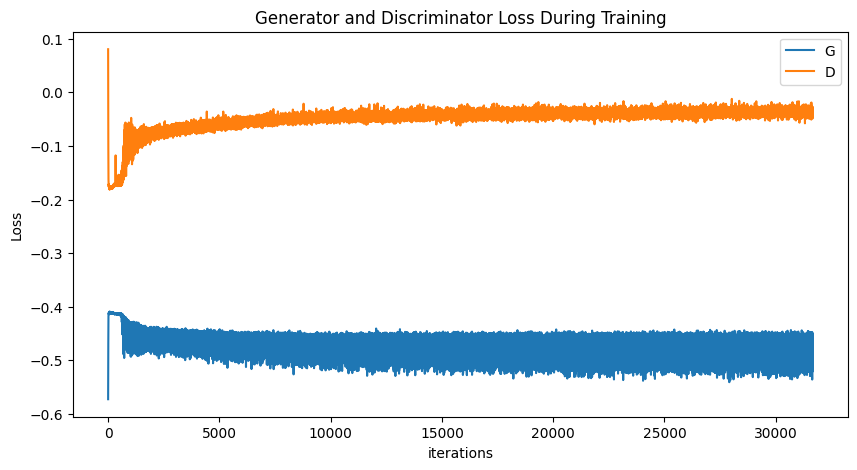

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Generator and Discriminator Loss During Training')
plt.plot(G_losses, label='G')
plt.plot(D_losses, label='D')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis('off')

ims = [[plt.imshow(np.transpose(img_list[2*index-1], (1,2,0)), animated=True)] for index in range(len(img_list) // 2)]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
new_noise = torch.randn(30, dim_latent_vector, 1, 1, device=device)
new_generated_imgs = generator(new_noise)
predict = discriminator(new_generated_imgs).view(-1)
print(predict)

In [ ]:
plt.figure(figsize=(10,10))

for i in range(9):
    image = new_generated_imgs[i]
    # Making image (3, 64, 64) to (64, 64, 3)
    image = image.permute(1,2,0)
    # Making elements of arrays from [-1,1] to [0,1]
    image = (image+1)/2
    ax=plt.subplot(3,3,i+1)
    plt.imshow(image.numpy())
    plt.axis('off')